In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
os.chdir("..")

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################


RUNNING ANALYSIS 1/1
Alpha: 0.007, Beta: 1.21


  0%|          | 0/343 [00:00<?, ?it/s]

Computing statistics for standardization


100%|██████████| 343/343 [00:59<00:00,  5.79it/s]



DEBUG: Overall data statistics across all batches:
TARGET DATA STATISTICS:
pr: mean=-0.000000, std=0.999953, min=-2.337, max=2.657
tasmin: mean=0.000000, std=0.999952, min=-4.407, max=2.916
tasmax: mean=-0.000000, std=0.999955, min=-2.922, max=9.545

INPUT DATA STATISTICS:
pr: mean=-0.001083, std=0.920203, min=-2.337, max=2.409
tasmin: mean=-0.011823, std=1.011059, min=-5.337, max=2.574
tasmax: mean=0.065930, std=1.030788, min=-2.498, max=11.899

WEIGHT FUNCTION ANALYSIS STATISTICS
Theoretical weight=1.0 threshold: 4.10
Weight function: w(y) = min(0.007 * exp(1.21 * y), 1.0)
------------------------------------------------------------

PR:
  Target Range: [-2.337, 2.657]
  Target Mean±Std: -0.000±1.000
  Weight Range: [0.000, 0.174]
  Weight Mean: 0.013
  % of weights = 1.0: 0.0%
  % above threshold (4.1): 0.0%

TASMIN:
  Target Range: [-4.407, 2.916]
  Target Mean±Std: 0.000±1.000
  Weight Range: [0.000, 0.239]
  Weight Mean: 0.013
  % of weights = 1.0: 0.0%
  % above threshold (4.1)

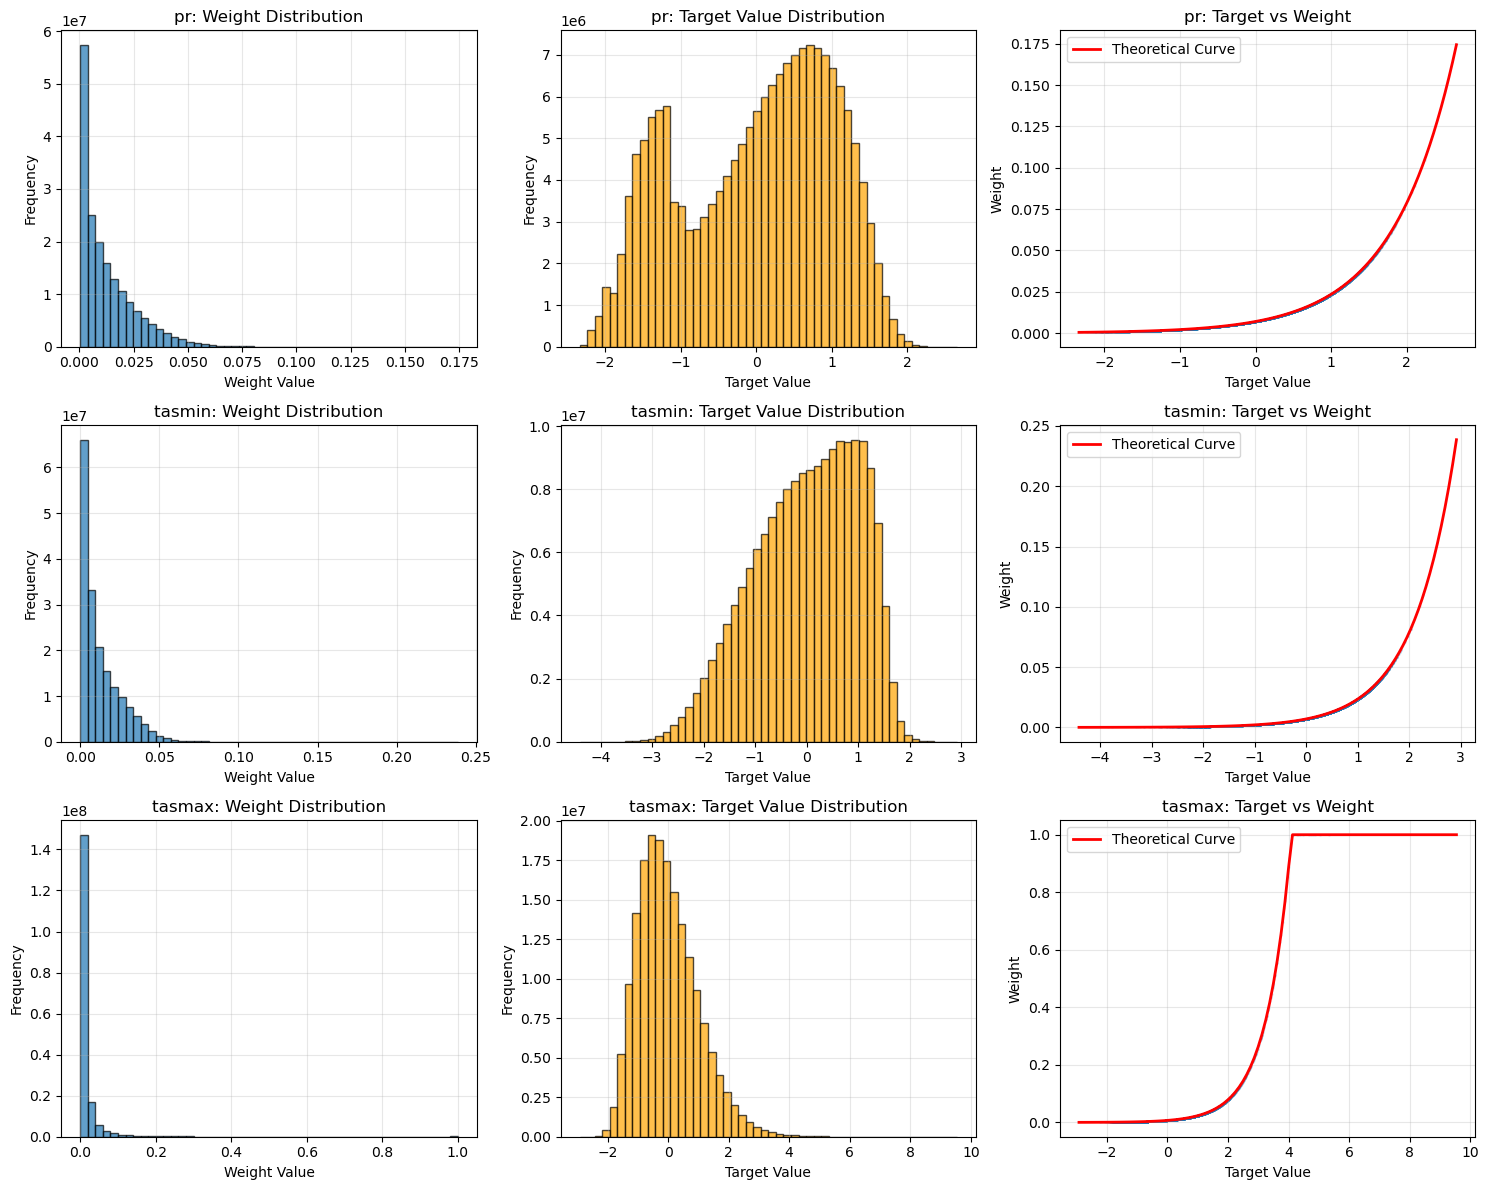

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import climex_utils as cu
import train_prob_unet_model as tm

def analyze_weight_function(dataloader, variables, alpha=0.007, beta=0.048, 
                          num_batches=50, save_dir="./results/weight_analysis/hr_stats"):
    """
    Analyze the weighting function behavior for each variable separately.
    
    Args:
        dataloader: DataLoader for the training data
        variables: List of variable names ['pr', 'tasmax', 'tasmin']
        alpha, beta: Weighting function parameters
        num_batches: Number of batches to analyze (to manage memory)
        save_dir: Directory to save plots and results
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Storage for each variable
    all_targets = {var: [] for var in variables}
    all_weights = {var: [] for var in variables}

    # Storage for computing overall statistics
    all_targets_stats = {var: [] for var in variables}
    all_inputs_stats = {var: [] for var in variables}
    
    print("Collecting target values and computing weights...")
    
    # Collect data from multiple batches
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            if i >= num_batches:  # Limit to manage memory
                break
                
            targets = batch['targets']  # Shape: [B, C, H, W]
            inputs = batch['inputs']    # Shape: [B, C, H, W]

            # Collect data for overall statistics computation
            for var_idx, var_name in enumerate(variables):
                targets_flat = targets[:, var_idx, :, :].flatten()
                inputs_flat = inputs[:, var_idx, :, :].flatten()
                
                all_targets_stats[var_name].extend(targets_flat.cpu().numpy())
                all_inputs_stats[var_name].extend(inputs_flat.cpu().numpy())
    
            
            # Process each variable separately
            for var_idx, var_name in enumerate(variables):
                var_targets = targets[:, var_idx, :, :].flatten().numpy()
                
                # Compute weights for this variable
                var_weights = np.clip(alpha * np.exp(beta * var_targets), a_min=None, a_max=1.0)
                
                all_targets[var_name].extend(var_targets)
                all_weights[var_name].extend(var_weights)
    
    # Convert to numpy arrays
    for var_name in variables:
        all_targets[var_name] = np.array(all_targets[var_name])
        all_weights[var_name] = np.array(all_weights[var_name])
    
    for var_name in variables:
        all_targets_stats[var_name] = np.array(all_targets_stats[var_name])
        all_inputs_stats[var_name] = np.array(all_inputs_stats[var_name])

    # Print overall statistics after processing all batches
    print("\n" + "="*60)
    print("DEBUG: Overall data statistics across all batches:")
    print("="*60)

    print("TARGET DATA STATISTICS:")
    for var_idx, var_name in enumerate(variables):
        var_data = all_targets_stats[var_name]
        print(f"{var_name}: mean={var_data.mean():.6f}, std={var_data.std():.6f}, min={var_data.min():.3f}, max={var_data.max():.3f}")

    print("\nINPUT DATA STATISTICS:")
    for var_idx, var_name in enumerate(variables):
        var_data = all_inputs_stats[var_name]
        print(f"{var_name}: mean={var_data.mean():.6f}, std={var_data.std():.6f}, min={var_data.min():.3f}, max={var_data.max():.3f}")


    # Create analysis plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for i, var_name in enumerate(variables):
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # 1. Weight distribution histogram
        axes[i, 0].hist(weights, bins=50, alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'{var_name}: Weight Distribution')
        axes[i, 0].set_xlabel('Weight Value')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        # 2. Target distribution histogram
        axes[i, 1].hist(targets, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[i, 1].set_title(f'{var_name}: Target Value Distribution')
        axes[i, 1].set_xlabel('Target Value')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        # 3. Target vs Weight scatter plot (subsample for readability)
        sample_size = min(10000, len(targets))
        indices = np.random.choice(len(targets), sample_size, replace=False)
        
        axes[i, 2].scatter(targets[indices], weights[indices], alpha=0.1, s=1)
        axes[i, 2].set_title(f'{var_name}: Target vs Weight')
        axes[i, 2].set_xlabel('Target Value')
        axes[i, 2].set_ylabel('Weight')
        axes[i, 2].grid(True, alpha=0.3)
        
        # Add theoretical curve
        target_range = np.linspace(targets.min(), targets.max(), 100)
        theoretical_weights = np.clip(alpha * np.exp(beta * target_range), a_min=None, a_max=1.0)
        axes[i, 2].plot(target_range, theoretical_weights, 'r-', linewidth=2, 
                       label='Theoretical Curve')
        axes[i, 2].legend()
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/weight_analysis_overview.png", dpi=300, bbox_inches='tight')
    # plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("WEIGHT FUNCTION ANALYSIS STATISTICS")
    print("="*60)
    
    threshold_value = np.log(1/alpha) / beta
    print(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}")
    print(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)")
    print("-"*60)
    
    for var_name in variables:
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # Calculate statistics
        min_target = targets.min()
        max_target = targets.max()
        mean_target = targets.mean()
        std_target = targets.std()
        
        min_weight = weights.min()
        max_weight = weights.max()
        mean_weight = weights.mean()
        
        # Percentage of weights = 1.0
        pct_max_weight = (weights >= 0.999).mean() * 100  # Use 0.999 for numerical precision
        
        # Values above threshold
        above_threshold = (targets > threshold_value).mean() * 100
        
        print(f"\n{var_name.upper()}:")
        print(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]")
        print(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}")
        print(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]")
        print(f"  Weight Mean: {mean_weight:.3f}")
        print(f"  % of weights = 1.0: {pct_max_weight:.1f}%")
        print(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%")
    
    # Save detailed statistics to file
    stats_file = f"{save_dir}/weight_statistics.txt"
    with open(stats_file, 'w') as f:
        f.write("WEIGHT FUNCTION ANALYSIS STATISTICS\n")
        f.write("="*60 + "\n")
        f.write(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}\n")
        f.write(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)\n")
        f.write("-"*60 + "\n")
        
        for var_name in variables:
            targets = all_targets[var_name]
            weights = all_weights[var_name]
            
            min_target = targets.min()
            max_target = targets.max()
            mean_target = targets.mean()
            std_target = targets.std()
            min_weight = weights.min()
            max_weight = weights.max()
            mean_weight = weights.mean()
            pct_max_weight = (weights >= 0.999).mean() * 100
            above_threshold = (targets > threshold_value).mean() * 100
            
            f.write(f"\n{var_name.upper()}:\n")
            f.write(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]\n")
            f.write(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}\n")
            f.write(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]\n")
            f.write(f"  Weight Mean: {mean_weight:.3f}\n")
            f.write(f"  % of weights = 1.0: {pct_max_weight:.1f}%\n")
            f.write(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%\n")
    
    print(f"\nDetailed statistics saved to: {stats_file}")
    return all_targets, all_weights

args = tm.get_args()
args.years_train = list(range(1960, 1990))
dataset_train = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_train,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_hr",
    transfo=True
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

# Define parameter combinations to test
param_combinations = [
    {"alpha": 0.007, "beta": 1.21},  # Original parameters,    # Lower alpha, higher beta
]

# Run analysis for each parameter combination
for i, params in enumerate(param_combinations):
    alpha = params["alpha"]
    beta = params["beta"]
    
    print(f"\n{'='*60}")
    print(f"RUNNING ANALYSIS {i+1}/{len(param_combinations)}")
    print(f"Alpha: {alpha}, Beta: {beta}")
    print(f"{'='*60}")
    
    # Create unique save directory for this parameter combination
    save_dir = f"./weight_analysis/hr_stats/alpha_{alpha}_beta_{beta}_lrinterp_to_hr"
    
    # Run the analysis
    targets_dict, weights_dict = analyze_weight_function(
        dataloader=dataloader_train,
        variables=args.variables,  # ['pr', 'tasmax', 'tasmin']
        alpha=alpha,
        beta=beta,
        num_batches=500,
        save_dir=save_dir
    )
    
    print(f"Results saved to: {save_dir}")

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################


RUNNING ANALYSIS 1/1
Alpha: 0.007, Beta: 1.21


  0%|          | 0/343 [00:00<?, ?it/s]

Computing statistics for standardization


100%|██████████| 343/343 [01:00<00:00,  5.68it/s]



DEBUG: Overall data statistics across all batches:
TARGET DATA STATISTICS:
pr: mean=0.000000, std=1.094288, min=-2.316, max=2.896
tasmin: mean=0.000000, std=1.029531, min=-6.101, max=3.235
tasmax: mean=0.000000, std=1.274687, min=-4.013, max=14.707

INPUT DATA STATISTICS:
pr: mean=0.000000, std=0.999953, min=-2.316, max=2.466
tasmin: mean=0.000000, std=0.999955, min=-4.020, max=2.488
tasmax: mean=-0.000000, std=0.999955, min=-2.480, max=8.795

WEIGHT FUNCTION ANALYSIS STATISTICS
Theoretical weight=1.0 threshold: 4.10
Weight function: w(y) = min(0.007 * exp(1.21 * y), 1.0)
------------------------------------------------------------

PR:
  Target Range: [-2.316, 2.896]
  Target Mean±Std: 0.000±1.094
  Weight Range: [0.000, 0.233]
  Weight Mean: 0.014
  % of weights = 1.0: 0.0%
  % above threshold (4.1): 0.0%

TASMIN:
  Target Range: [-6.101, 3.235]
  Target Mean±Std: 0.000±1.030
  Weight Range: [0.000, 0.351]
  Weight Mean: 0.013
  % of weights = 1.0: 0.0%
  % above threshold (4.1): 0.

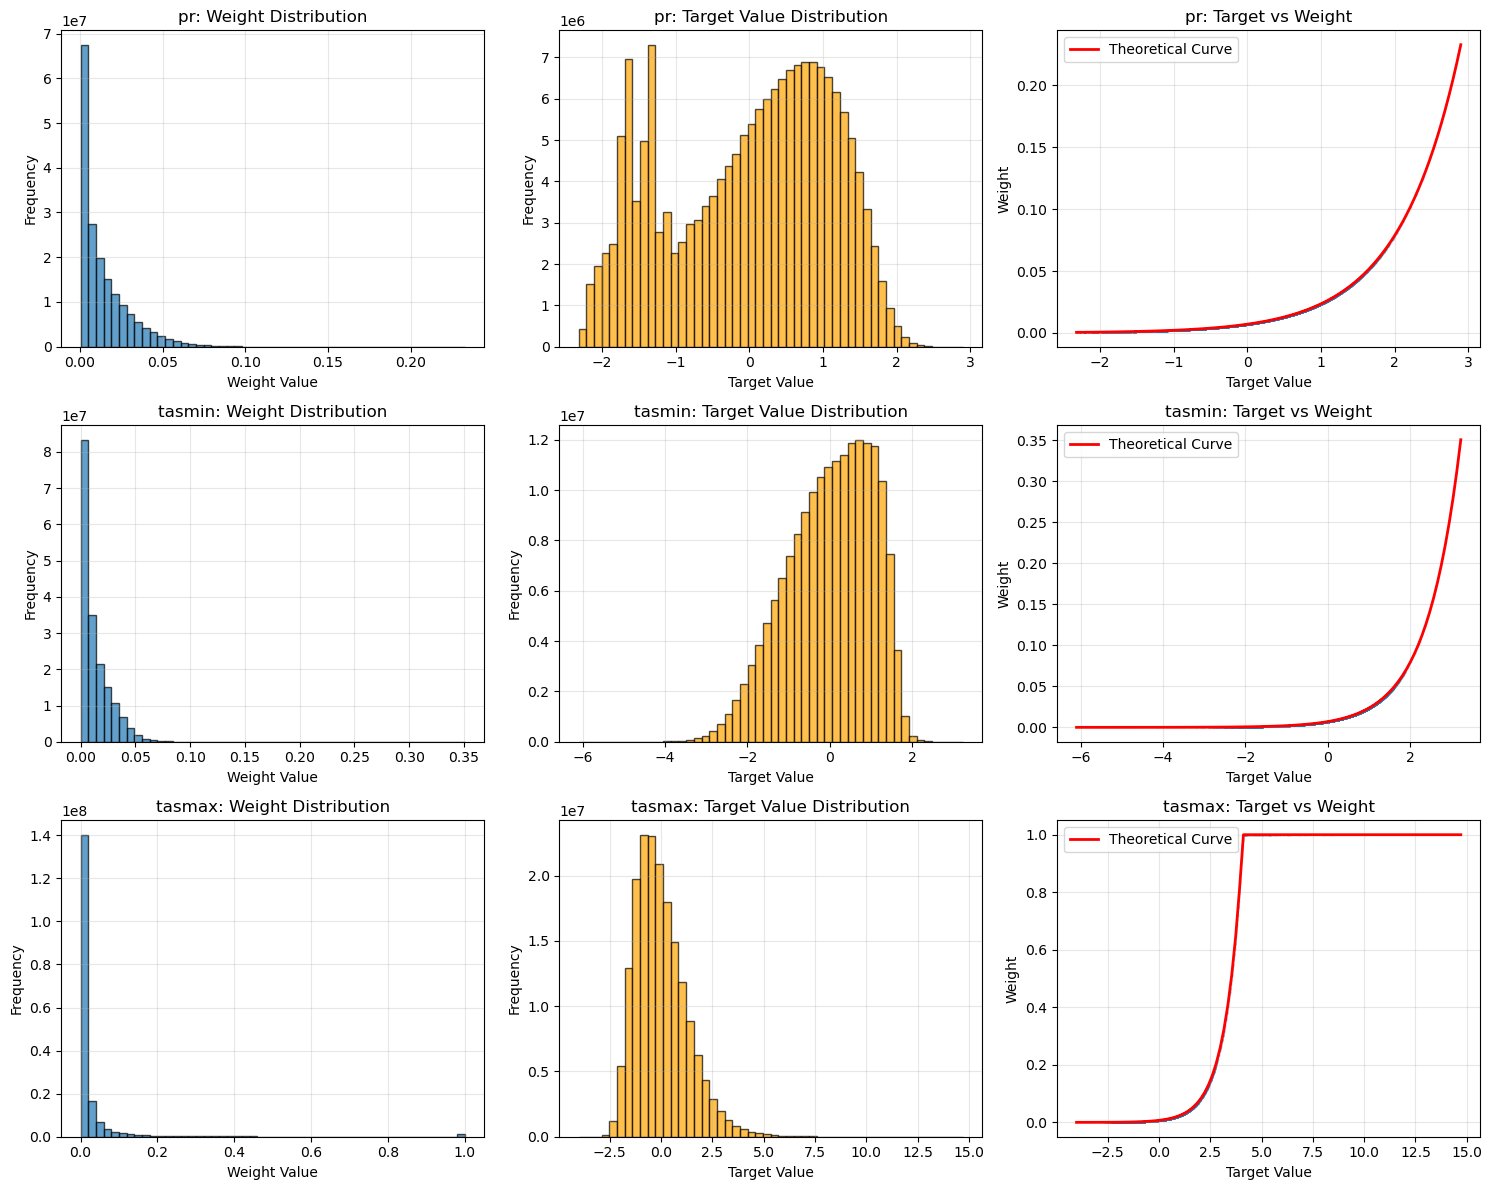

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import climex_utils as cu
import train_prob_unet_model as tm

def analyze_weight_function(dataloader, variables, alpha=0.007, beta=0.048, 
                          num_batches=50, save_dir="./results/weight_analysis/lrinterp_to_hr"):
    """
    Analyze the weighting function behavior for each variable separately.
    
    Args:
        dataloader: DataLoader for the training data
        variables: List of variable names ['pr', 'tasmax', 'tasmin']
        alpha, beta: Weighting function parameters
        num_batches: Number of batches to analyze (to manage memory)
        save_dir: Directory to save plots and results
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Storage for each variable
    all_targets = {var: [] for var in variables}
    all_weights = {var: [] for var in variables}

    # Storage for computing overall statistics
    all_targets_stats = {var: [] for var in variables}
    all_inputs_stats = {var: [] for var in variables}
    
    print("Collecting target values and computing weights...")
    
    # Collect data from multiple batches
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            if i >= num_batches:  # Limit to manage memory
                break
                
            targets = batch['targets']  # Shape: [B, C, H, W]
            inputs = batch['inputs']    # Shape: [B, C, H, W]

            # Collect data for overall statistics computation
            for var_idx, var_name in enumerate(variables):
                targets_flat = targets[:, var_idx, :, :].flatten()
                inputs_flat = inputs[:, var_idx, :, :].flatten()
                
                all_targets_stats[var_name].extend(targets_flat.cpu().numpy())
                all_inputs_stats[var_name].extend(inputs_flat.cpu().numpy())
        

            # Process each variable separately
            for var_idx, var_name in enumerate(variables):
                var_targets = targets[:, var_idx, :, :].flatten().numpy()
                
                # Compute weights for this variable
                var_weights = np.clip(alpha * np.exp(beta * var_targets), a_min=None, a_max=1.0)
                
                all_targets[var_name].extend(var_targets)
                all_weights[var_name].extend(var_weights)

    # Convert statistics arrays to numpy
    for var_name in variables:
        all_targets_stats[var_name] = np.array(all_targets_stats[var_name])
        all_inputs_stats[var_name] = np.array(all_inputs_stats[var_name])

    # Convert to numpy arrays
    for var_name in variables:
        all_targets[var_name] = np.array(all_targets[var_name])
        all_weights[var_name] = np.array(all_weights[var_name])
    
    # Print overall statistics after processing all batches
    print("\n" + "="*60)
    print("DEBUG: Overall data statistics across all batches:")
    print("="*60)

    print("TARGET DATA STATISTICS:")
    for var_idx, var_name in enumerate(variables):
        var_data = all_targets_stats[var_name]
        print(f"{var_name}: mean={var_data.mean():.6f}, std={var_data.std():.6f}, min={var_data.min():.3f}, max={var_data.max():.3f}")

    print("\nINPUT DATA STATISTICS:")
    for var_idx, var_name in enumerate(variables):
        var_data = all_inputs_stats[var_name]
        print(f"{var_name}: mean={var_data.mean():.6f}, std={var_data.std():.6f}, min={var_data.min():.3f}, max={var_data.max():.3f}")

    # Create analysis plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for i, var_name in enumerate(variables):
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # 1. Weight distribution histogram
        axes[i, 0].hist(weights, bins=50, alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'{var_name}: Weight Distribution')
        axes[i, 0].set_xlabel('Weight Value')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        # 2. Target distribution histogram
        axes[i, 1].hist(targets, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[i, 1].set_title(f'{var_name}: Target Value Distribution')
        axes[i, 1].set_xlabel('Target Value')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        # 3. Target vs Weight scatter plot (subsample for readability)
        sample_size = min(10000, len(targets))
        indices = np.random.choice(len(targets), sample_size, replace=False)
        
        axes[i, 2].scatter(targets[indices], weights[indices], alpha=0.1, s=1)
        axes[i, 2].set_title(f'{var_name}: Target vs Weight')
        axes[i, 2].set_xlabel('Target Value')
        axes[i, 2].set_ylabel('Weight')
        axes[i, 2].grid(True, alpha=0.3)
        
        # Add theoretical curve
        target_range = np.linspace(targets.min(), targets.max(), 100)
        theoretical_weights = np.clip(alpha * np.exp(beta * target_range), a_min=None, a_max=1.0)
        axes[i, 2].plot(target_range, theoretical_weights, 'r-', linewidth=2, 
                       label='Theoretical Curve')
        axes[i, 2].legend()
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/weight_analysis_overview.png", dpi=300, bbox_inches='tight')
    # plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("WEIGHT FUNCTION ANALYSIS STATISTICS")
    print("="*60)
    
    threshold_value = np.log(1/alpha) / beta
    print(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}")
    print(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)")
    print("-"*60)
    
    for var_name in variables:
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # Calculate statistics
        min_target = targets.min()
        max_target = targets.max()
        mean_target = targets.mean()
        std_target = targets.std()
        
        min_weight = weights.min()
        max_weight = weights.max()
        mean_weight = weights.mean()
        
        # Percentage of weights = 1.0
        pct_max_weight = (weights >= 0.999).mean() * 100  # Use 0.999 for numerical precision
        
        # Values above threshold
        above_threshold = (targets > threshold_value).mean() * 100
        
        print(f"\n{var_name.upper()}:")
        print(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]")
        print(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}")
        print(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]")
        print(f"  Weight Mean: {mean_weight:.3f}")
        print(f"  % of weights = 1.0: {pct_max_weight:.1f}%")
        print(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%")
    
    # Save detailed statistics to file
    stats_file = f"{save_dir}/weight_statistics.txt"
    with open(stats_file, 'w') as f:
        f.write("WEIGHT FUNCTION ANALYSIS STATISTICS\n")
        f.write("="*60 + "\n")
        f.write(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}\n")
        f.write(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)\n")
        f.write("-"*60 + "\n")
        
        for var_name in variables:
            targets = all_targets[var_name]
            weights = all_weights[var_name]
            
            min_target = targets.min()
            max_target = targets.max()
            mean_target = targets.mean()
            std_target = targets.std()
            min_weight = weights.min()
            max_weight = weights.max()
            mean_weight = weights.mean()
            pct_max_weight = (weights >= 0.999).mean() * 100
            above_threshold = (targets > threshold_value).mean() * 100
            
            f.write(f"\n{var_name.upper()}:\n")
            f.write(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]\n")
            f.write(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}\n")
            f.write(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]\n")
            f.write(f"  Weight Mean: {mean_weight:.3f}\n")
            f.write(f"  % of weights = 1.0: {pct_max_weight:.1f}%\n")
            f.write(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%\n")
    
    print(f"\nDetailed statistics saved to: {stats_file}")
    return all_targets, all_weights

args = tm.get_args()

dataset_train = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_train,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_hr",
    transfo=True
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

# Define parameter combinations to test
param_combinations = [
    {"alpha": 0.007, "beta": 1.21},  # Original parameters,    # Lower alpha, higher beta
]

# Run analysis for each parameter combination
for i, params in enumerate(param_combinations):
    alpha = params["alpha"]
    beta = params["beta"]
    
    print(f"\n{'='*60}")
    print(f"RUNNING ANALYSIS {i+1}/{len(param_combinations)}")
    print(f"Alpha: {alpha}, Beta: {beta}")
    print(f"{'='*60}")
    
    # Create unique save directory for this parameter combination
    save_dir = f"./weight_analysis/lrinterp_to_hr/alpha_{alpha}_beta_{beta}"
    
    # Run the analysis
    targets_dict, weights_dict = analyze_weight_function(
        dataloader=dataloader_train,
        variables=args.variables,  # ['pr', 'tasmax', 'tasmin']
        alpha=alpha,
        beta=beta,
        num_batches=500,
        save_dir=save_dir
    )
    
    print(f"Results saved to: {save_dir}")

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################


RUNNING RAW HR ANALYSIS 1/1
Alpha: 0.007, Beta: 0.0481


  0%|          | 0/343 [00:00<?, ?it/s]

Computing statistics for standardization


100%|██████████| 343/343 [00:28<00:00, 11.83it/s]


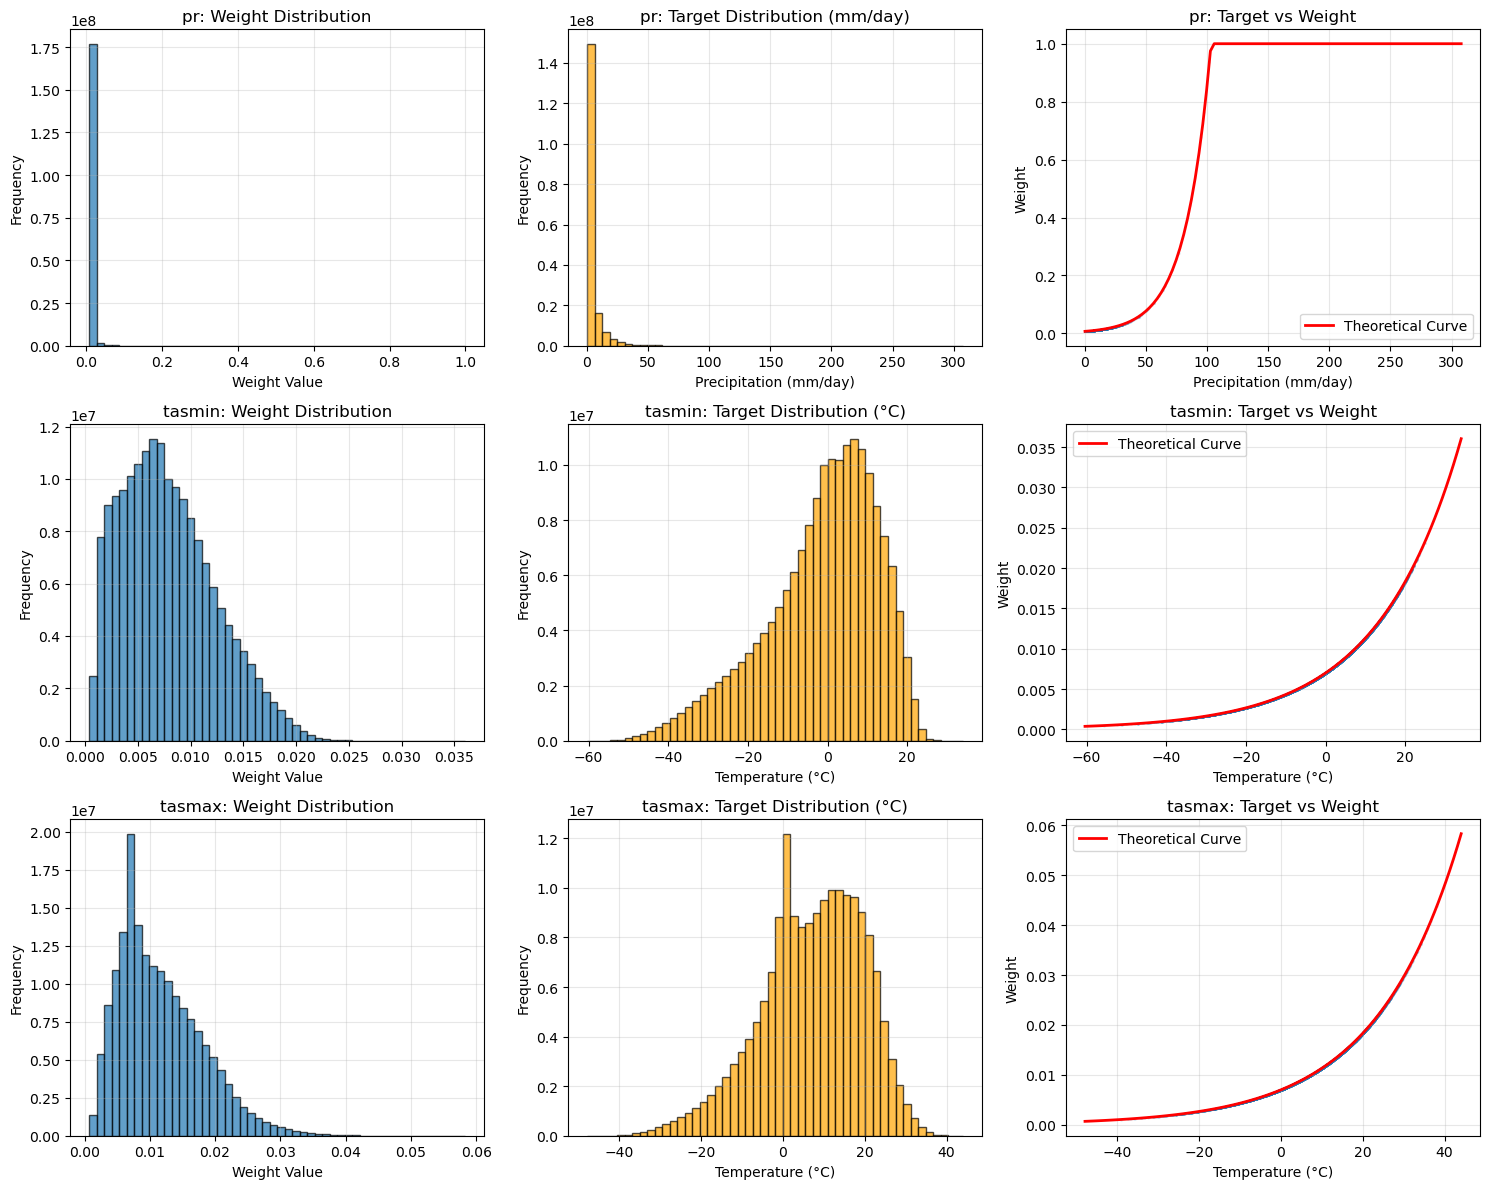


WEIGHT FUNCTION ANALYSIS - RAW HIGH-RESOLUTION DATA
Theoretical weight=1.0 threshold: 103.16
Weight function: w(y) = min(0.007 * exp(0.0481 * y), 1.0)
------------------------------------------------------------

PR (mm/day):
  Target Range: [0.002, 307.876]
  Target Mean±Std: 3.470±6.868
  Weight Range: [0.007, 1.000]
  Weight Mean: 0.009
  % of weights = 1.0: 0.0%
  % above threshold (103.2): 0.0%

TASMIN (°C):
  Target Range: [-60.406, 34.069]
  Target Mean±Std: -1.510±14.090
  Weight Range: [0.000, 0.036]
  Weight Mean: 0.008
  % of weights = 1.0: 0.0%
  % above threshold (103.2): 0.0%

TASMAX (°C):
  Target Range: [-47.802, 44.070]
  Target Mean±Std: 7.141±12.451
  Weight Range: [0.001, 0.058]
  Weight Mean: 0.012
  % of weights = 1.0: 0.0%
  % above threshold (103.2): 0.0%

Detailed statistics saved to: ./weight_analysis_raw_hr/alpha_0.007_beta_0.0481/weight_statistics_raw_hr.txt
Results saved to: ./weight_analysis_raw_hr/alpha_0.007_beta_0.0481


In [ ]:
# high-resolution data (non-standardized, non-residual)
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import climex_utils as cu
import train_prob_unet_model as tm

def analyze_weight_function_raw_hr(dataloader, variables, alpha=0.007, beta=0.048, 
                                 num_batches=50, save_dir="./weight_analysis_raw_hr"):
    """
    Analyze the weighting function behavior for non-transformed high-resolution data.
    
    Args:
        dataloader: DataLoader for the training data
        variables: List of variable names ['pr', 'tasmax', 'tasmin']
        alpha, beta: Weighting function parameters
        num_batches: Number of batches to analyze (to manage memory)
        save_dir: Directory to save plots and results
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Storage for each variable
    all_targets = {var: [] for var in variables}
    all_weights = {var: [] for var in variables}
    
    print("Collecting raw high-resolution target values and computing weights...")
    
    # Collect data from multiple batches
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            if i >= num_batches:  # Limit to manage memory
                break
                
            # Get the raw high-resolution data (non-standardized, non-residual)
            hr_raw = batch['hr']  # Shape: [B, C, H, W] - this is the raw transformed data
            
            # Apply inverse transformations to get back to physical units
            hr_physical = hr_raw.clone()
            
            # Process each variable separately
            for var_idx, var_name in enumerate(variables):
                if var_name == 'pr':
                    # For precipitation: apply softplus and convert to mm/day
                    if dataloader.dataset.transfo:
                        var_targets = cu.kgm2sTommday(cu.softplus(hr_physical[:, var_idx, :, :]))
                    else:
                        var_targets = cu.kgm2sTommday(hr_physical[:, var_idx, :, :])
                        
                elif var_name == 'tasmin':
                    # For minimum temperature: convert Kelvin to Celsius
                    var_targets = cu.KToC(hr_physical[:, var_idx, :, :])
                    
                elif var_name == 'tasmax':
                    # For maximum temperature: handle transformation if applied
                    if dataloader.dataset.transfo:
                        # tasmax was stored as transformed difference: softplus_inv(tasmax - tasmin)
                        # So: tasmax = softplus(transformed_diff) + tasmin
                        tasmin_raw = hr_physical[:, var_idx-1, :, :]  # Get tasmin
                        diff_transformed = hr_physical[:, var_idx, :, :]  # This is the transformed difference
                        var_targets = cu.KToC(cu.softplus(diff_transformed, c=0.) + tasmin_raw)
                    else:
                        var_targets = cu.KToC(hr_physical[:, var_idx, :, :])
                
                # Flatten and convert to numpy
                var_targets_flat = var_targets.flatten().numpy()
                
                # Compute weights for this variable using physical values
                var_weights = np.clip(alpha * np.exp(beta * var_targets_flat), a_min=None, a_max=1.0)
                
                all_targets[var_name].extend(var_targets_flat)
                all_weights[var_name].extend(var_weights)
    
    # Convert to numpy arrays
    for var_name in variables:
        all_targets[var_name] = np.array(all_targets[var_name])
        all_weights[var_name] = np.array(all_weights[var_name])
    
    # Create analysis plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for i, var_name in enumerate(variables):
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # 1. Weight distribution histogram
        axes[i, 0].hist(weights, bins=50, alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'{var_name}: Weight Distribution')
        axes[i, 0].set_xlabel('Weight Value')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        # 2. Target distribution histogram
        axes[i, 1].hist(targets, bins=50, alpha=0.7, edgecolor='black', color='orange')
        if var_name == 'pr':
            axes[i, 1].set_title(f'{var_name}: Target Distribution (mm/day)')
            axes[i, 1].set_xlabel('Precipitation (mm/day)')
        else:
            axes[i, 1].set_title(f'{var_name}: Target Distribution (°C)')
            axes[i, 1].set_xlabel('Temperature (°C)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        # 3. Target vs Weight scatter plot (subsample for readability)
        sample_size = min(10000, len(targets))
        indices = np.random.choice(len(targets), sample_size, replace=False)
        
        axes[i, 2].scatter(targets[indices], weights[indices], alpha=0.1, s=1)
        axes[i, 2].set_title(f'{var_name}: Target vs Weight')
        if var_name == 'pr':
            axes[i, 2].set_xlabel('Precipitation (mm/day)')
        else:
            axes[i, 2].set_xlabel('Temperature (°C)')
        axes[i, 2].set_ylabel('Weight')
        axes[i, 2].grid(True, alpha=0.3)
        
        # Add theoretical curve
        target_range = np.linspace(targets.min(), targets.max(), 100)
        theoretical_weights = np.clip(alpha * np.exp(beta * target_range), a_min=None, a_max=1.0)
        axes[i, 2].plot(target_range, theoretical_weights, 'r-', linewidth=2, 
                       label='Theoretical Curve')
        axes[i, 2].legend()
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/weight_analysis_raw_hr_overview.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("WEIGHT FUNCTION ANALYSIS - RAW HIGH-RESOLUTION DATA")
    print("="*60)
    
    threshold_value = np.log(1/alpha) / beta
    print(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}")
    print(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)")
    print("-"*60)
    
    for var_name in variables:
        targets = all_targets[var_name]
        weights = all_weights[var_name]
        
        # Calculate statistics
        min_target = targets.min()
        max_target = targets.max()
        mean_target = targets.mean()
        std_target = targets.std()
        
        min_weight = weights.min()
        max_weight = weights.max()
        mean_weight = weights.mean()
        
        # Percentage of weights = 1.0
        pct_max_weight = (weights >= 0.999).mean() * 100
        
        # Values above threshold
        above_threshold = (targets > threshold_value).mean() * 100
        
        # Set appropriate units
        if var_name == 'pr':
            unit = " (mm/day)"
        else:
            unit = " (°C)"
        
        print(f"\n{var_name.upper()}{unit}:")
        print(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]")
        print(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}")
        print(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]")
        print(f"  Weight Mean: {mean_weight:.3f}")
        print(f"  % of weights = 1.0: {pct_max_weight:.1f}%")
        print(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%")
    
    # Save detailed statistics to file
    stats_file = f"{save_dir}/weight_statistics_raw_hr.txt"
    with open(stats_file, 'w') as f:
        f.write("WEIGHT FUNCTION ANALYSIS - RAW HIGH-RESOLUTION DATA\n")
        f.write("="*60 + "\n")
        f.write(f"Theoretical weight=1.0 threshold: {threshold_value:.2f}\n")
        f.write(f"Weight function: w(y) = min({alpha} * exp({beta} * y), 1.0)\n")
        f.write("-"*60 + "\n")
        
        for var_name in variables:
            targets = all_targets[var_name]
            weights = all_weights[var_name]
            
            min_target = targets.min()
            max_target = targets.max()
            mean_target = targets.mean()
            std_target = targets.std()
            min_weight = weights.min()
            max_weight = weights.max()
            mean_weight = weights.mean()
            pct_max_weight = (weights >= 0.999).mean() * 100
            above_threshold = (targets > threshold_value).mean() * 100
            
            if var_name == 'pr':
                unit = " (mm/day)"
            else:
                unit = " (°C)"
            
            f.write(f"\n{var_name.upper()}{unit}:\n")
            f.write(f"  Target Range: [{min_target:.3f}, {max_target:.3f}]\n")
            f.write(f"  Target Mean±Std: {mean_target:.3f}±{std_target:.3f}\n")
            f.write(f"  Weight Range: [{min_weight:.3f}, {max_weight:.3f}]\n")
            f.write(f"  Weight Mean: {mean_weight:.3f}\n")
            f.write(f"  % of weights = 1.0: {pct_max_weight:.1f}%\n")
            f.write(f"  % above threshold ({threshold_value:.1f}): {above_threshold:.1f}%\n")
    
    print(f"\nDetailed statistics saved to: {stats_file}")
    return all_targets, all_weights

# Usage with the modified function
args = tm.get_args()

dataset_train = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_train,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_residuals",
    transfo=True
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

# Define parameter combinations to test
param_combinations = [
    {"alpha": 0.007, "beta": 0.0481},  # Your original parameters  
]

# Run analysis for each parameter combination
for i, params in enumerate(param_combinations):
    alpha = params["alpha"]
    beta = params["beta"]
    
    print(f"\n{'='*60}")
    print(f"RUNNING RAW HR ANALYSIS {i+1}/{len(param_combinations)}")
    print(f"Alpha: {alpha}, Beta: {beta}")
    print(f"{'='*60}")
    
    # Create unique save directory for this parameter combination
    save_dir = f"./weight_analysis_raw_hr/alpha_{alpha}_beta_{beta}"
    
    # Run the analysis on raw high-resolution data
    targets_dict, weights_dict = analyze_weight_function_raw_hr(
        dataloader=dataloader_train,
        variables=args.variables,  # ['pr', 'tasmax', 'tasmin']
        alpha=alpha,
        beta=beta,
        num_batches=500,
        save_dir=save_dir
    )
    
    print(f"Results saved to: {save_dir}")